# Signal Pre-processing

This notebook contains applications of signal pre-processing using an example data. 

In [5]:
import sys
sys.path.append('..')
from seizurecast.data.file_io import * 
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

In [6]:
# relabeling config
LEN_PRE = 15
LEN_POS = 60
SEC_GAP = 0

## Example data

In [7]:
train_path = '../../tusz_1_5_2/edf/train'
tcp_type = '01_tcp_ar'
patient_group = '004'
patient = '00000492'
session = 's003_2003_07_18'
token = '00000492_s003_t001'

In [8]:
f, s, l = read_1_token(os.path.join(train_path, tcp_type, patient_group, patient, session, token))
# #TODO: 1 should be np.array
s = np.array(s)

df0 = pd.DataFrame(s.transpose(), columns=["ch"+str(i) for i in range(0, 22)])
df0.head(3)

,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,...,ch12,ch13,ch14,ch15,ch16,ch17,ch18,ch19,ch20,ch21
0,-3.609122,-15.296270,-0.010000,-3.599122,6.288464,-8.997806,-6.308464,-8.098025,17.105831,-0.010000,...,-5.398683,-6.308464,-3.609122,-8.088025,-3.609122,-8.997806,6.288464,-4.498903,-5.398683,-8.997806
1,-3.609122,-14.396489,-1.809561,-2.699342,5.388683,-9.897586,-1.809561,-6.298464,9.007806,-1.809561,...,-2.699342,-1.809561,-3.609122,-5.388683,-4.508903,-8.997806,5.388683,-5.398683,-2.699342,-8.997806
2,-5.408683,-12.596928,-2.709342,-2.699342,4.488903,-8.997806,-2.709342,-6.298464,-10.787367,-2.709342,...,-0.899781,-2.709342,-5.408683,-6.288464,-2.709342,-9.897586,4.488903,-8.098025,-0.899781,-9.897586


## DC Offset

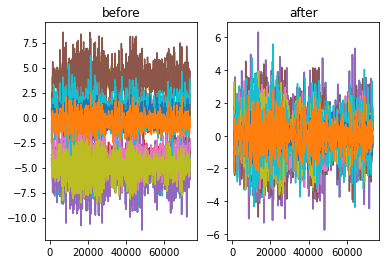

In [9]:
def remove_dc_offset(df:pd.DataFrame):
    return(df.apply(lambda x: x - np.mean(x)))

df = df0.apply(lambda x: x - np.mean(x))

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)

df0\
.iloc[:,:]\
.rolling(1000)\
.mean()\
.plot(title='before', legend=False, ax=axes[0])

df.rolling(1000).mean().plot(title='after', legend=False, ax=axes[1])

## Bandpass Filter

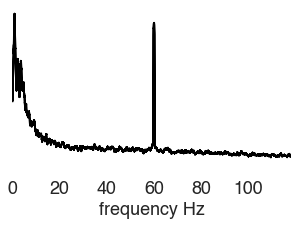

In [129]:
#FFT
import matplotlib.pyplot as plt
import scipy.fft as fft
    
def plot():    
    df_fft = df.apply(lambda x: np.abs(fft.fft(x.to_numpy())))
    freq = df_fft.apply(lambda x: np.abs(fft.fftfreq(len(x.to_numpy()))) * 400)[['ch0']].to_numpy()
    df_fft = df_fft.assign(freq=freq)

    yplot = df_fft.loc[:,['freq']+['ch'+str(i) for i in range(8,9)]].rolling(100).mean().to_numpy()
    plt.figure(figsize=[5,3])
    plt.plot(yplot[:,0], yplot[:,1], 'k')
    plt.yticks([])
    plt.xlim([0,118])
    plt.xticks(fontsize=18, fontname='Helvetica')
    plt.xlabel('frequency Hz', fontsize=18, fontname='Helvetica')
    plt.savefig('tmp.png', dpi=300)
    
    return df_fft

df_fft=plot()
# low pass needed

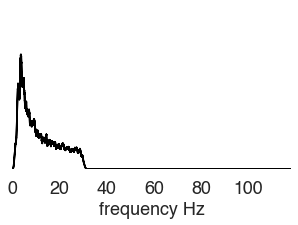

In [130]:
#FFT
import matplotlib.pyplot as plt
import scipy.fft as fft
from scipy import signal

    
def plot():    
    filter = signal.firwin(400, [0.01, 0.15], pass_zero=False)
    df_fft = df.apply(lambda x: np.abs(fft.fft(signal.convolve(x.to_numpy(), filter, mode='same'))))    
    freq = df_fft.apply(lambda x: np.abs(fft.fftfreq(len(x.to_numpy()))) * 400)[['ch0']].to_numpy()
    df_fft = df_fft.assign(freq=freq)

    yplot = df_fft.loc[:,['freq']+['ch'+str(i) for i in range(8,9)]].rolling(100).mean().to_numpy()
    plt.figure(figsize=[5,3])
    plt.plot(yplot[:,0], yplot[:,1], 'k')
    plt.yticks([])
    plt.ylim([0, 17600])
    plt.xlim([0,118])
    plt.xticks(fontsize=18, fontname='Helvetica')
    plt.xlabel('frequency Hz', fontsize=18, fontname='Helvetica')
    plt.savefig('tmp2.png', dpi=300)
    
    return df_fft

df_fft_new=plot()
# low pass needed

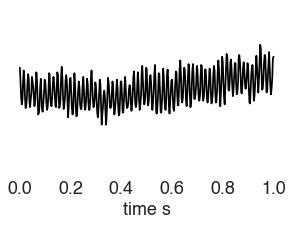

In [162]:
def plot():
    y = df.loc[5000:5000+400*1,['ch8']].rolling(1).mean().to_numpy()
    plt.figure(figsize=[5,3])
    plt.plot(np.arange(0,400*1+1) / 400, y, 'k')
    plt.ylim([-80, 80])
    plt.yticks([])
#     plt.xlim([0,30])
    plt.xticks(fontsize=18, fontname='Helvetica')
    plt.xlabel('time s', fontsize=18, fontname='Helvetica')
    plt.savefig('tmp3.png', dpi=300)
plot()

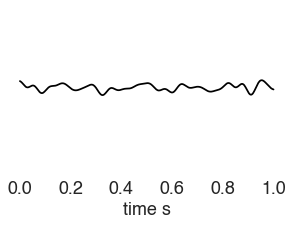

In [163]:
def plot2():
    df1 = df.apply(lambda x: np.real(signal.convolve(x.to_numpy(), filter, mode='same')))
    y = df1.loc[5000:5000+400*1,['ch8']].rolling(1).mean().to_numpy()
    plt.figure(figsize=[5,3])
    plt.plot(np.arange(0,400*1+1) / 400, y, 'k')
    plt.ylim([-80, 80])
    plt.yticks([])
#     plt.xlim([0,30])
    plt.xticks(fontsize=18, fontname='Helvetica')
    plt.xlabel('time s', fontsize=18, fontname='Helvetica')
    plt.savefig('tmp4.png', dpi=300)
    return df1
df1=plot2()

## Channel Selection
statistics of each channels and their correlation

In [15]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df1, minimal=True, explorative=True)

# profile.to_notebook_iframe()

##### Summary statistics

In [17]:
# channels_stats = df1.describe()\
#     .append(df.skew().rename('skew'))\
#     .append(df.kurtosis().rename('kurt'))
# channels_stats

##### Correlation

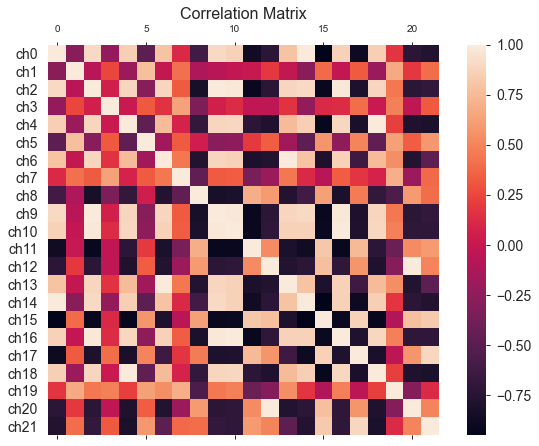

In [19]:
def plot_corrmat(corrmat, columns):
    f = plt.figure(figsize=(10, 7))
    plt.matshow(corrmat, fignum=f.number)
#     plt.xticks(range(len(columns)), columns, fontsize=14, rotation=45)
    plt.yticks(range(len(columns)), columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);
    
channels_corrmat = df1.corr()
plot_corrmat(channels_corrmat, df1.columns)

In [2]:
# plt.hist(channels_corrmat)

strong correlation between multiple channels. Consider reduce the number of channels.

In [20]:
# eig_vals, eig_vecs = np.linalg.eig(channels_corrmat)
# ranks = np.real(np.diag(eig_vecs))

# # print('Eigenvectors \n%s' %eig_vecs)
# print('\nEigenvalues \n%s' % np.real(eig_vals))
# sum(np.real(np.diag(eig_vecs)) > 1e-5)
# plt.subplot(1,2,1), plt.hist(np.real(np.diag(eig_vecs))), plt.title('Rank')
# plt.subplot(1,2,2), plt.hist(np.real(eig_vals)), plt.title('Eigen Values')

In [21]:
np.sum(np.array(abs(channels_corrmat)>0.9),0)

array([5, 1, 8, 1, 3, 1, 2, 1, 1, 8, 5, 5, 2, 2, 5, 7, 5, 1, 3, 1, 2, 1])

### Drop Channels

Load 50 tokens files randomly selected from the database

In [23]:
# import pickle
# if os.path.isfile('../tmp/eda.pkl'):
#     with open('../tmp/eda.pkl', 'rb') as fp:
#         dfs = pickle.load(fp)
# else:
#     dfs = []
#     for token in token_paths:
#         dfs.append(process(token))
#     with open('../tmp/eda.pkl', 'wb') as fp:
#         pickle.dump(dfs, fp)

Plot the averaged correlation matrix of the 50 tokens.

In [31]:
ch_cor_mats = [df1.corr() for df1 in [df1]]

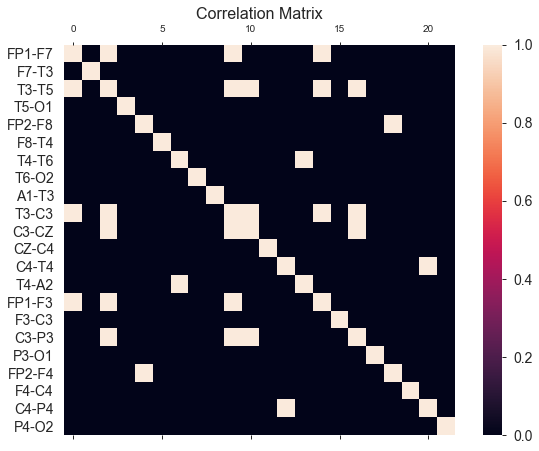

In [36]:
chmatdf = pd.DataFrame(ch_cor_mats[0])
for i in range(1,1):
    chmatdf += pd.DataFrame(ch_cor_mats[i])
plot_corrmat(chmatdf>0.9, l)

Channels and their locations on the head.
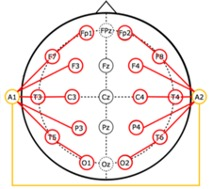

It seems many channels are strongly correlated with each other. For randomly sampled 50 patients. the strongly correlated channels corresponds to line #3 and #4

In [19]:
# Drop channels
dfs = [dfs[i][['ch'+str(i) for i in range(0,8)]] for i in range(0, len(dfs))]

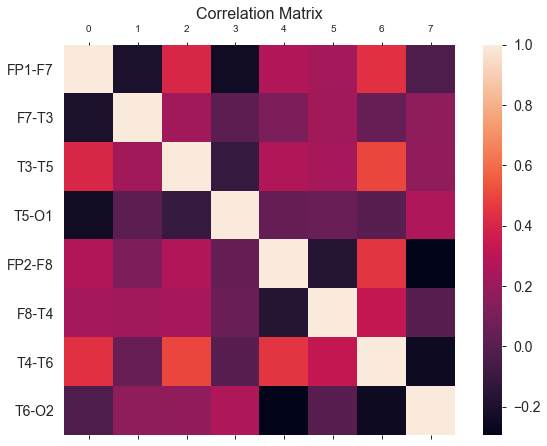

In [20]:
ch_cor_mats = [df1.corr() for df1 in dfs]
# pd.DataFrame([np.sum(np.array(abs(chmat)>0.8),0) for chmat in ch_cor_mats], columns=l)
chmatdf = pd.DataFrame(ch_cor_mats[0])
for i in range(1,10):
    chmatdf += pd.DataFrame(ch_cor_mats[i])
plot_corrmat(chmatdf/10, l[0:8])

In [21]:
eig_vals, eig_vecs = np.linalg.eig(chmatdf)
ranks = np.real(np.diag(eig_vecs))
eig_vals, ranks


(array([23.36150628, 15.25455826,  4.71565861,  2.38641842,  3.03375783,
        11.52653114, 10.14298139,  9.57858806]),
 array([ 0.45866848,  0.48278774, -0.54126103, -0.34452388, -0.21737091,
        -0.33937729,  0.05705283,  0.4072627 ]))

In [22]:
def drop_channels(df):
    return df.iloc[:,0:8]

## Resampling to 256 Hz

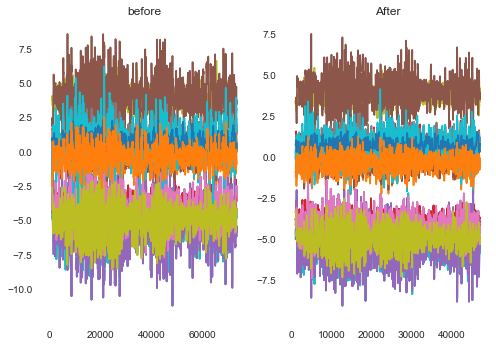

In [39]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)

f, s, l = read_1_token(os.path.join(train_path, tcp_type, patient_group, patient, session, token))
pd.DataFrame(np.transpose(s)).rolling(1000).mean()\
    .plot(legend=False, title='before', ax=axes[0])

num=int(np.shape(s)[1]*256/np.mean(f))

np.random.seed(10)
s = signal.resample(s, num=num, axis=1)
pd.DataFrame(np.transpose(s)).rolling(1000).mean()\
    .plot(legend=False, title='After', ax=axes[1])